# Exercise 10 image stitching
Today’s exercise is different from the previous weeks in that it has only a few exercises followed \
by multiple options for how to improve your algorithm. You are going to implement an algorithm \
that can stitch at least two images together, by using RANSAC to estimate a homography.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm


### EX 10.1 SIFT Features

Load images and find the features of both.

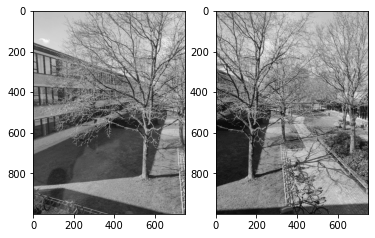

In [2]:
# Load image
left_color = cv2.imread('week10_data/im2.jpg')
left = cv2.cvtColor(left_color, cv2.COLOR_RGB2GRAY)
right_color = cv2.imread('week10_data/im1.jpg')
right = cv2.cvtColor(right_color, cv2.COLOR_RGB2GRAY)
'''
# Need to scale down images for better visualization
scale_percent = 20 # percent of original size
width = int(right.shape[1] * scale_percent / 100)
height = int(right.shape[0] * scale_percent / 100)
dim = (width, height)

# resize image
right = cv2.resize(right, dim, interpolation = cv2.INTER_AREA)
left = cv2.resize(left, dim, interpolation = cv2.INTER_AREA)
'''
# Show
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(left, cmap="gray")
ax[1].imshow(right, cmap="gray");

In [125]:
# 1 SIFT
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(left, None)
kp2, des2 = sift.detectAndCompute(right, None)

# 2 KNN match with two (best and second best)
bf = cv2.BFMatcher()
knn_matches = bf.knnMatch(des1, des2, k=2)
all_matches = bf.match(des1, des2)

# 3 Ratio test!
# We should not do the ratio test for RANSAC!
kp1_indexes = []
kp2_indexes = []
ratio_matches = []
for m,n in knn_matches:
    if m.distance < 0.90*n.distance:
        ratio_matches.append([m])
        kp1_indexes.append(m.queryIdx)
        kp2_indexes.append(m.trainIdx)

## Go from tuple -> array
kp1 = np.asarray(kp1)
kp2 = np.asarray(kp2)

## 4 extract the keypoints of the "good" matches
match_points1_ratio = [p.pt for p in kp1[kp1_indexes]]
match_points2_ratio = [p.pt for p in kp2[kp2_indexes]]

p1_ratio = np.array(match_points1_ratio).astype(np.float32)
p2_ratio = np.array(match_points2_ratio).astype(np.float32)

p1s_ratio = np.vstack((p1_ratio.T, np.ones(p1_ratio.shape[0])))
p2s_ratio = np.vstack((p2_ratio.T, np.ones(p2_ratio.shape[0])))

## OR! use all matches!

p1 = np.float32([kp1[m.queryIdx].pt for m in all_matches])
p2 = np.float32([kp2[m.trainIdx].pt for m in all_matches])

p1s = np.vstack((p1.T, np.ones(p1.shape[0])))
p2s = np.vstack((p2.T, np.ones(p2.shape[0])))

# To test the built in function
src_pts = np.float32([kp1[m.queryIdx].pt for m in all_matches]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in all_matches]).reshape(-1,1,2)


print("ALL:", p1s.shape, p2s.shape)
print("Ratio:", p1s_ratio.shape, p2s_ratio.shape)

ALL: (3, 6200) (3, 6200)
Ratio: (3, 1395) (3, 1395)


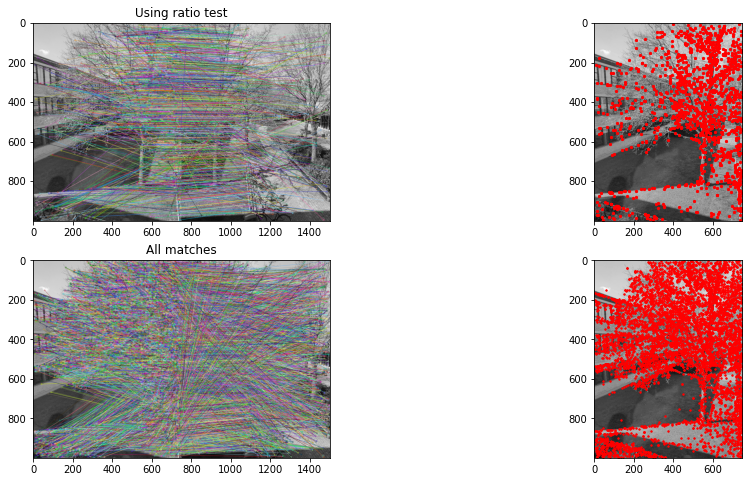

In [126]:
match_image_ratio = cv2.drawMatchesKnn(left,kp1,right,kp2, ratio_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
match_image_all = cv2.drawMatches(left,kp1,right,kp2, all_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
axs[0, 0].set_title("Using ratio test")
axs[0, 0].imshow(match_image_ratio)
axs[0, 1].scatter(p1_ratio[:, 0], p1_ratio[:, 1], s=5, c="red")
axs[1, 0].set_title("All matches")
axs[0, 1].imshow(left, cmap="gray")
axs[1, 0].imshow(match_image_all)
axs[1, 1].scatter(p1[:, 0], p1[:, 1], s=2, c="red")
axs[1, 1].imshow(left, cmap="gray");

### 10.2 Implement RANSAC for finding homographies between the images.

What is the minimum number of matches you need to estimate a homography?
- H matrix is 3x3, with 9 DoF. But as H is scale invariant (as its multiplying homogenous points) it only has 8 DoF
- Each pair of points imposes 2 constraints (x,y), meaning that four points gives 8 constraints.
- In conclusion, we need four pairs of points.

Use Equation (2.45) from the lecture notes to compute the distance of a match to a homography. \
Assume σ = 3 and use the formulas from the lecture last week to determine the threshold for when \
a match should be considered an inlier. 

While best practice would be to determine the number of  iterations while running the algorithm,\
you can fix it to i.e. 200. 

To verify that the inliers of the best model are reasonable, visualize them.\
Consider using the following code: 
```plt.imshow(cv2.drawMatches(im1, kp1, im2, kp2, np.array(matches)[bestInliers], None))```\

**NB** On the provided images you should find in the ballpark of a thousand inliers

***From week 4***

In [5]:
def hest(q1,q2):
    """
    Estimates H given points Q1, Q2 on the two image planes. 
    Need at least 4 pairs of points to estimate the matrix with 8 degrees of freedom.
    """
    q1,T1 = normalize2d(q1)
    q2,T2 = normalize2d(q2)
    assert len(q1[0])>1, "We need at least two points (aka two columns)"
    assert len(q1[0])==len(q2[0]), "Number of column of q1 and q2 must be equal!"
    B = get_b(q1,q2) #np.vstack((B0,B1))
    _,_,VT = np.linalg.svd(B.T@B) #U,S,VT = np.linalg.svd(np.hstack((B.T,B)))
    H = np.reshape(VT[-1],(3,3)) # VT is sorted in descending order of singular value
    return (np.linalg.inv(T1)@H.T@T2.round(2))

def normalize2d(Q):
    mean = np.mean(Q,axis=1)
    std = np.std(Q,axis=1)
    T = np.array([[1/std[0],0,-mean[0]/std[0]],
                  [0,1/std[1],-mean[1]/std[1]],
                 [0,0,1]])
    return [T@Q, T]

def crossop(p):
    return np.array([[0,-p[2],p[1]],
                    [p[2],0,-p[0]],
                    [-p[1],p[0],0]])

def get_b(q1,q2):
    B = np.kron(q2[:,0], crossop(q1[:,0]))
    for i in range(1,len(q1.T)):
        B_temp = np.kron(q2[:,i], crossop(q1[:,i]))
        B = np.vstack((B,B_temp))
    return B

def PI(q):
    return q[:2]/q[2]

***RANSAC TIME***

In [212]:
def approx_dist(Hest, p1, p2):
    """
    Absolute squared distance between the 
    reprojections from one image plane to the other.
    """
    # Non-homogenous to get actual distances.
    q1 = PI(p1)
    q2 = PI(p2)

    # Approximate distance, using matched points.
    left_dist = q1 - PI(Hest@p2)

    try:
        right_dist = q2 - PI(np.linalg.inv(Hest)@p1)
    except np.linalg.LinAlgError:
        right_dist = q2 - PI(np.linalg.pinv(Hest)@p1)

    return np.linalg.norm(left_dist, axis=0, ord=2)**2 + np.linalg.norm(right_dist, axis=0, ord=2)**2


def consensus(Hest, q1, q2, sigma):
    '''
    Counts no. inliers given an estimated H. 
    Also returns the index of the inliers.
    '''
    # Threshold given the KJI-square distribution again,
    # as the distance we calculate is squared.
    threshold = 3.84*sigma**2
    inliers_index = []
    inliers_index = np.where(approx_dist(Hest, q1, q2)<threshold)[0]
    return len(inliers_index), np.asarray(inliers_index)

def RANSAC_hest(p1s, p2s, sigma=3, iterations=5000):
    # RANSAC iterations
    best_inlier_count = 0
    best_inlier_idx = None
    H_best=None
    #Loop
    for i in tqdm(range(iterations)):
        # Draw eight random matches
        match_idx = np.random.randint(low=0, high=len(p1s[0]), size=(8,))
        p1_sample = p1s[:, match_idx]
        p2_sample = p2s[:, match_idx]
        # Estimate the homography
        H_est = hest(p1_sample,p2_sample)
        # Find no. inliers
        no_inliers, inlier_index = consensus(H_est, p1s, p2s, sigma)
        if no_inliers>best_inlier_count:
            best_inlier_count = no_inliers
            best_inlier_idx = inlier_index
            H_best = H_est
            #print(i, "New best estimate!")

    # Now, use all inliers of best F to match a final F
    print("Inliers count:", best_inlier_count)
    H_final = hest(p1s[:, best_inlier_idx], p2s[:, best_inlier_idx])
    if H_final[1, 1]==0:
        print("Bad final match")
        return H_best, best_inlier_idx
    return H_final, best_inlier_idx

***Test the RANSAC***

In [215]:
Hest, inlier_index = RANSAC_hest(p1s_ratio, p2s_ratio, sigma=30, iterations=2000)

100%|██████████| 2000/2000 [00:02<00:00, 837.42it/s]

Inliers count: 335
Bad final match


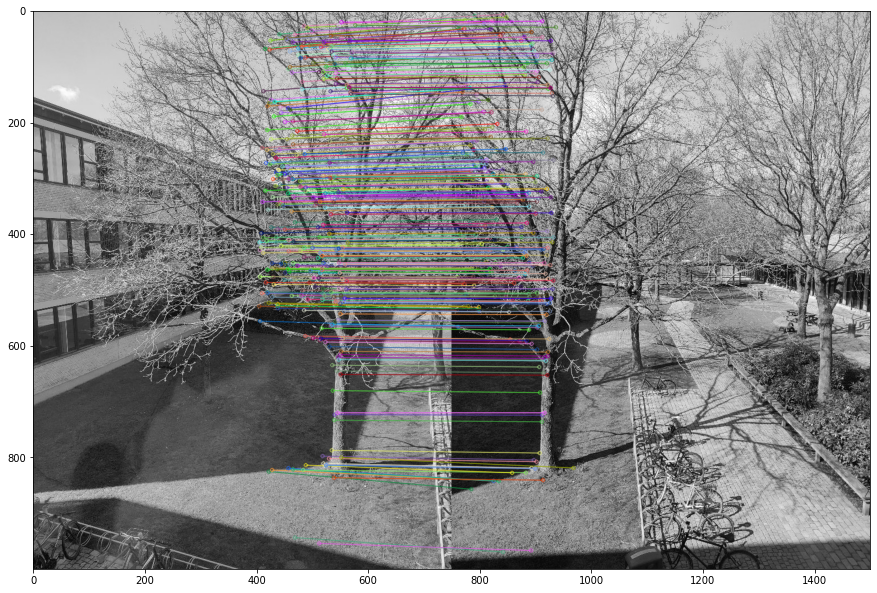

In [216]:
plt.figure(figsize=(15, 15))
plt.imshow(cv2.drawMatchesKnn(left,kp1,right,kp2, np.array(ratio_matches)[inlier_index], None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS));
#plt.imshow(cv2.drawMatches(left,kp1,right,kp2, np.array(all_matches)[inlier_index], None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS));

***The Homography we found managed to neatly trim down the matches, but will it be useful for stitching?***

### 10.3 Big wrapper function

### 10.4 Warping images.

The warping function takes an image and a homography and returns the image warped with the homography, where \
xRange and yRange specifies for which range of x and y values the image should be sampled. The function returns \
the transformed version of the image, and a mask that is 1 where the image is valid.

Start out by setting:
```
xRange = [0, im1.shape[1]]
yRange = [0, im1.shape[0]]
```

Warp one of your images using the estimated homography. Which image you should warp, depends on if you have found \
the homography going from image one to two or vice versa. This should warp this image to the other, thus cutting \
off a lot of the content of that image.

Use the warping function on the other image but set the homography to the identity. \
Change xRange and yRange so the images are no longer getting cropped by the warp.


In [189]:

def warpImage(im, H, xRange, yRange):
    T = np.eye(3)
    T[:2, 2] = [-xRange[0], -yRange[0]]
    H = T@H
    outSize = (xRange[1]-xRange[0], yRange[1]-yRange[0])
    imWarp = cv2.warpPerspective(im, H, outSize)
    maskWarp = cv2.warpPerspective(np.ones(im.shape[:2], dtype=np.uint8), H, outSize)
    return imWarp, maskWarp

In [217]:
# Home made 
H, inlier_index = RANSAC_hest(p1s_ratio, p2s_ratio, sigma=30, iterations=20000)
overlap_points = p2[inlier_index]
H

100%|██████████| 20000/20000 [00:22<00:00, 881.82it/s]


Inliers count: 886
Bad final match


array([[ 3.84132581e-01,  5.78167741e-03,  2.51802327e+02],
       [-1.41541873e-01,  6.07947588e-01,  2.40161249e+01],
       [-2.86518677e-04,  2.44704870e-05,  6.27894485e-01]])

***MY own H matrix***

Useful pixel left 0.5357142857142857
Useful pixel right 0.6245478571428571


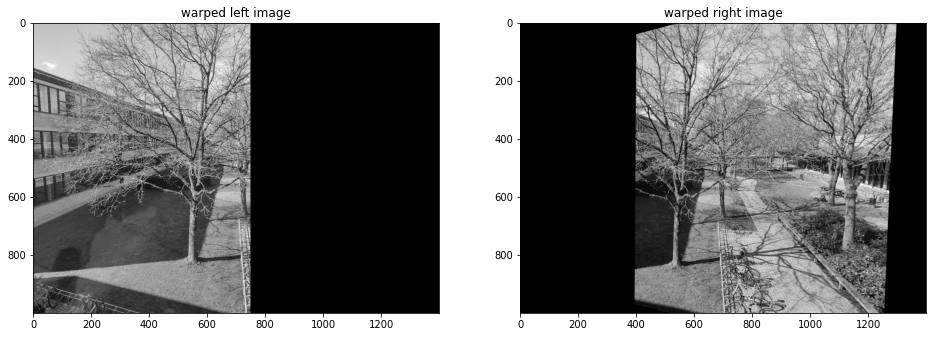

In [218]:
#xRange = [0, left.shape[1]]
#yRange = [0, left.shape[0]]

xRange = [0, 1400]
yRange = [0, left.shape[0]]

left_warp, left_mask = warpImage(left, np.identity(3), xRange, yRange)
print("Useful pixel left", np.mean(left_mask))

right_warp, right_mask = warpImage(right, H, xRange, yRange)
print("Useful pixel right", np.mean(right_mask))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,12))
axs[0].imshow(left_warp, cmap="gray")
axs[0].set_title("warped left image")
axs[1].imshow(right_warp, cmap="gray")
axs[1].set_title("warped right image");

### 10.5 Combine images

Use the mask returned by the warping function, to generate a single image that contains both \
images. Where the images overlap you can use the intensities from either image.

**TODO** Use the mask to interpolate in the overlaps
**TODO** Use non-linear optimization of the final hest?

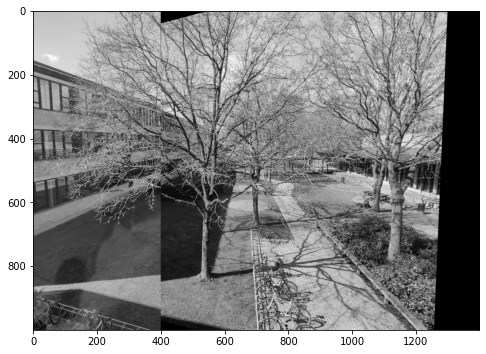

In [220]:
# Since the right image is the base image, we use the left image as canvas, and draw the right image on top.
canvas = right_warp.copy()
#canvas[:, 0:left.shape[1]] = left_warp[:, 0:left.shape[1]]
canvas[:, 0:400] = left_warp[:, 0:400]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
axs.imshow(canvas, cmap="gray");

***Compare to built in***

In [173]:
# Built in comparison
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
matchesMask = mask.ravel().tolist() # List of what matches were used in final.
len(src_pts), len(matchesMask)

(6200, 6200)

In [181]:
M*1/M[0,0], H*1/H[0,0]

(array([[ 1.00000000e+00,  1.79973955e-02, -4.07008298e+02],
        [ 2.54825045e-01,  9.09212310e-01, -1.42447119e+02],
        [ 5.42913600e-04,  3.50820294e-06,  6.03164547e-01]]),
 array([[ 1.00000000e+00,  0.00000000e+00,  7.19836880e+02],
        [-4.32735945e-01,  0.00000000e+00,  7.58341496e+01],
        [-9.21048748e-04,  0.00000000e+00,  1.77071255e+00]]))

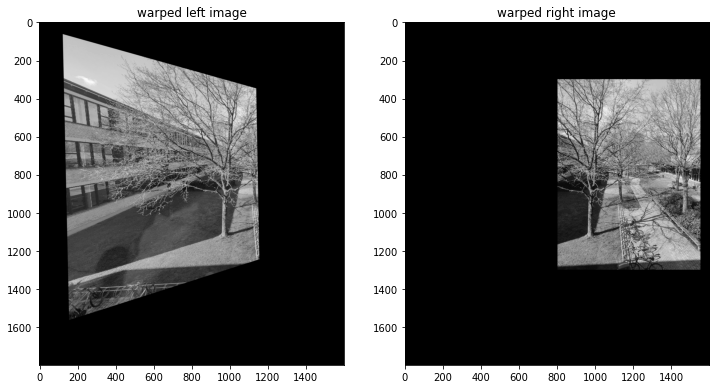

In [174]:
#xRange = [0, left.shape[1]]
#yRange = [0, left.shape[0]]

xRange = [-800, 800]
yRange = [-300, 1500]

left_warp, left_mask = warpImage(left, M, xRange, yRange)

right_warp, right_mask = warpImage(right, np.identity(3), xRange, yRange)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
axs[0].imshow(left_warp, cmap="gray")
axs[0].set_title("warped left image")
axs[1].imshow(right_warp, cmap="gray")
axs[1].set_title("warped right image");

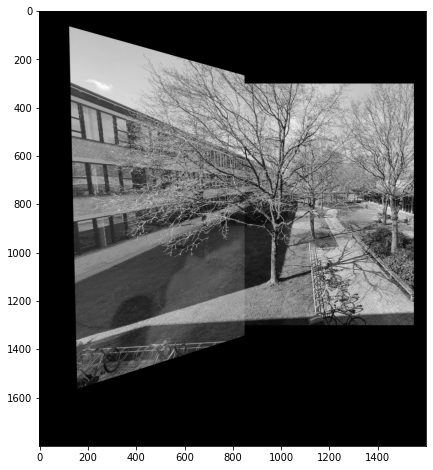

In [175]:
# Since the right image is the base image, we use the left image as canvas, and draw the right image on top.
canvas = left_warp.copy()
canvas[:, -right.shape[1]:] = right_warp[:, -right.shape[1]:]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
axs.imshow(canvas, cmap="gray");